In [30]:
import sys
import os
import importlib   

sys.path.append(os.path.join(os.getcwd(), 'NeuralNetworks'))
import multiLayerNN as FC
importlib.reload(FC)

import torch
import matplotlib.pyplot as plt

In [31]:
torch.manual_seed(15)
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
def u_exact(x:torch.Tensor):
    # u_g = torch.log(x+2) + torch.cos(2*x + x**3)
    u_g = torch.sin(2*x + 1) + 0.2*torch.exp(1.3*x)
    # u_g = x**3/(0.01 + x**4)
    return u_g

In [33]:
def calculate_kappa(x):
    nb_zeros = torch.where(x[0:-1, 0] * x[1:, 0] < 0)[0]
    kappa = 3*(nb_zeros.shape[0])
    return kappa

In [41]:
class OneStageFCNN():
    def __init__(self, x_train, u_train, hidden_size, kappa, lower_bound, upper_bound, activation_func):
        super(OneStageFCNN, self).__init__()

        assert isinstance(x_train, torch.cuda.DoubleTensor)
        assert isinstance(u_train, torch.cuda.DoubleTensor)
        
        self.u_scale = torch.sqrt(torch.mean(u_train**2))
        # self.u_scale = torch.max(torch.abs(u_train))
        self.loss_scale = self.u_scale**2
        self.x_train = x_train
        self.u_train = u_train/self.u_scale

        self.hidden_size = hidden_size
        self.kappa = kappa
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.activation_func = activation_func

        self.model = FC.FullyConnectedNetwork(domain_bounds=[lower_bound, upper_bound], kappa=kappa, input_dim=1, hidden_size=hidden_size, actv=activation_func).to(device)
        self.model_optimizer = 'defined in train'
        self.loss_criterion = 'defined in train'

    def _adam_train(self, n_iter):
        loss_criterion = self.loss_criterion
        model_optimizer = self.model_optimizer

        for iter_i in range(n_iter):
            model_optimizer.zero_grad()
            u_pred = self.model(self.x_train)
            loss_value = loss_criterion(u_pred, self.u_train)
            loss_value.backward(retain_graph=True)
            model_optimizer.step()

            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value*self.loss_scale}")

    def _closure(self):
        self.model_optimizer.zero_grad()
        u_pred = self.model(self.x_train)
        loss_value = self.loss_criterion(u_pred, self.u_train)
        loss_value.backward(retain_graph=True) 
        return loss_value
    
    def _lbfgs_train(self, n_iter):
        for iter_i in range(n_iter):
            loss_value = self.model_optimizer.step(self._closure)
            if iter_i % 100 == 0:
                print(f"Iteration {iter_i}, Loss: {loss_value*self.loss_scale}")

    def train(self, n_iter, method):
        self.loss_criterion = torch.nn.MSELoss()
        if method == 1:
            self.model_optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0005)
            self._adam_train(n_iter)
        elif method == 2:
            self.model_optimizer = torch.optim.LBFGS(self.model.parameters(), lr=0.01, max_iter=n_iter//3, tolerance_grad=1e-11, line_search_fn='strong_wolfe')
            self._lbfgs_train(n_iter)

    def predict(self, x_to_predict):
        u_pred = self.model(x_to_predict) * self.u_scale
        return u_pred



In [46]:
nb_training_points = 1501
x_train = torch.linspace(-1.02, 1.02, nb_training_points).reshape(-1,1).to(device)
u_train = u_exact(x_train)

low_bound_xtrain, up_bound_xtrain = x_train.min(), x_train.max()

nb_evaluation_points = 8000
x_eval = torch.linspace(-1, 1, nb_evaluation_points).reshape(-1,1).to(device)
u_eval = u_exact(x_eval)

In [47]:
# Fist stage of training

model1 = OneStageFCNN(x_train, u_train, hidden_size=20, kappa=1, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=0)
model1.train(10000, 1)
model1.train(1000, 2)
u_p = model1.predict(x_eval)

Iteration 0, Loss: 0.9893124788090809
Iteration 100, Loss: 0.08501671717065817
Iteration 200, Loss: 0.070312264293771
Iteration 300, Loss: 0.04400361420074734
Iteration 400, Loss: 0.019754034937822854
Iteration 500, Loss: 0.008809941341228637
Iteration 600, Loss: 0.0061590441952925285
Iteration 700, Loss: 0.0051759022600344415
Iteration 800, Loss: 0.004459593552961625
Iteration 900, Loss: 0.003886042281212287
Iteration 1000, Loss: 0.003420258071198174
Iteration 1100, Loss: 0.0030368469484461065
Iteration 1200, Loss: 0.0027165728580382464
Iteration 1300, Loss: 0.0024449367054940143
Iteration 1400, Loss: 0.0022108883472227543
Iteration 1500, Loss: 0.0020057866394747543
Iteration 1600, Loss: 0.0018227875937653086
Iteration 1700, Loss: 0.0016565678123138983
Iteration 1800, Loss: 0.0015031559013936149
Iteration 1900, Loss: 0.0013597429612775473
Iteration 2000, Loss: 0.001224468930673985
Iteration 2100, Loss: 0.0010962214366595099
Iteration 2200, Loss: 0.0009744682309522241
Iteration 2300, L

In [48]:
# Second stage of the training

u_train2 = u_train - model1.predict(x_train)
kappa2 = calculate_kappa(u_train2)

model2 = OneStageFCNN(x_train, u_train2, hidden_size=20, kappa=kappa2, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model2.train(20000, 1)
model2.train(1000, 2)
u_pred2 = model2.predict(x_eval)
u_p2 = u_p + u_pred2

Iteration 0, Loss: 1.9719299888993936e-06
Iteration 100, Loss: 1.877808113789693e-07
Iteration 200, Loss: 6.324552691823181e-08
Iteration 300, Loss: 2.3838977574029168e-08
Iteration 400, Loss: 1.1125812911894763e-08
Iteration 500, Loss: 6.000728532453489e-09
Iteration 600, Loss: 3.5734092306406452e-09
Iteration 700, Loss: 2.304803529203799e-09
Iteration 800, Loss: 1.6061862761483542e-09
Iteration 900, Loss: 1.204505206833301e-09
Iteration 1000, Loss: 9.587371419144992e-10
Iteration 1100, Loss: 7.960785967602281e-10
Iteration 1200, Loss: 6.801048557100578e-10
Iteration 1300, Loss: 5.924060885636494e-10
Iteration 1400, Loss: 5.230589824926415e-10
Iteration 1500, Loss: 4.662856680949726e-10
Iteration 1600, Loss: 4.1852493372096146e-10
Iteration 1700, Loss: 3.774953302522853e-10
Iteration 1800, Loss: 3.4168518264520487e-10
Iteration 1900, Loss: 3.1005682998953007e-10
Iteration 2000, Loss: 2.818715083953525e-10
Iteration 2100, Loss: 2.5658446388563173e-10
Iteration 2200, Loss: 2.33780927930

In [50]:
# Third stage of the training
nb_training_points_strengthening = 4801
x_train_strengthening = torch.linspace(-1.02, 1.02, nb_training_points_strengthening).reshape(-1,1).to(device)
u_train_strengthening = u_exact(x_train_strengthening)

u_train3 = u_train_strengthening - model1.predict(x_train_strengthening) - model2.predict(x_train_strengthening)
kappa3 = calculate_kappa(u_train3)

model3 = OneStageFCNN(x_train_strengthening, u_train3, hidden_size=30, kappa=kappa3, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model3.train(5000, 1)
model3.train(30000, 2)
u_pred3 = model3.predict(x_eval)
u_p3 = u_p2 + u_pred3

Iteration 0, Loss: 1.7527457472074134e-12
Iteration 100, Loss: 6.997408406936232e-13
Iteration 200, Loss: 5.202712735781373e-13
Iteration 300, Loss: 4.041865759484263e-13
Iteration 400, Loss: 3.225449142275639e-13
Iteration 500, Loss: 2.493666016188746e-13
Iteration 600, Loss: 1.8409118823321804e-13
Iteration 700, Loss: 1.3401333404899146e-13
Iteration 800, Loss: 9.777117670951584e-14
Iteration 900, Loss: 7.585399717542539e-14
Iteration 1000, Loss: 5.971366324702808e-14
Iteration 1100, Loss: 4.921234000868947e-14
Iteration 1200, Loss: 4.079371321863265e-14
Iteration 1300, Loss: 3.782787286530323e-14
Iteration 1400, Loss: 2.917038112476577e-14
Iteration 1500, Loss: 3.2482890520195676e-14
Iteration 1600, Loss: 2.241095732912476e-14
Iteration 1700, Loss: 1.940785607945464e-14
Iteration 1800, Loss: 1.7086387281267498e-14
Iteration 1900, Loss: 1.531965332737437e-14
Iteration 2000, Loss: 1.45113575152049e-14
Iteration 2100, Loss: 1.221019593399651e-14
Iteration 2200, Loss: 1.1059565997854366

In [51]:
# Fourth stage of the training
u_train4 = u_train_strengthening - model1.predict(x_train_strengthening).detach() - model2.predict(x_train_strengthening).detach() - model3.predict(x_train_strengthening).detach()
kappa4 = calculate_kappa(u_train4)

model4 = OneStageFCNN(x_train_strengthening, u_train4, hidden_size=30, kappa=kappa4, lower_bound=low_bound_xtrain, upper_bound=up_bound_xtrain, activation_func=1)
model4.train(5000, 1)
model4.train(40000, 2)
u_pred4 = model4.predict(x_eval)

u_p4 = u_p3 + u_pred4

Iteration 0, Loss: 4.9582333594058785e-17
Iteration 100, Loss: 3.459072982545564e-17
Iteration 200, Loss: 2.8331701966515665e-17
Iteration 300, Loss: 2.0226718829458366e-17
Iteration 400, Loss: 1.4667998235226936e-17
Iteration 500, Loss: 1.2218048282747806e-17
Iteration 600, Loss: 1.1142029031315332e-17
Iteration 700, Loss: 1.0570509584102014e-17
Iteration 800, Loss: 1.0202452099410837e-17
Iteration 900, Loss: 9.942486266718299e-18
Iteration 1000, Loss: 9.819086316931215e-18
Iteration 1100, Loss: 9.741672875527498e-18
Iteration 1200, Loss: 9.44734983248733e-18
Iteration 1300, Loss: 9.288836952316726e-18
Iteration 1400, Loss: 9.21307745609015e-18
Iteration 1500, Loss: 9.09275689187669e-18
Iteration 1600, Loss: 9.183084388596862e-18
Iteration 1700, Loss: 8.89093591658543e-18
Iteration 1800, Loss: 8.832096931881245e-18
Iteration 1900, Loss: 9.055612108558956e-18
Iteration 2000, Loss: 8.642813103693179e-18
Iteration 2100, Loss: 8.714268211069337e-18
Iteration 2200, Loss: 8.534759528457703e

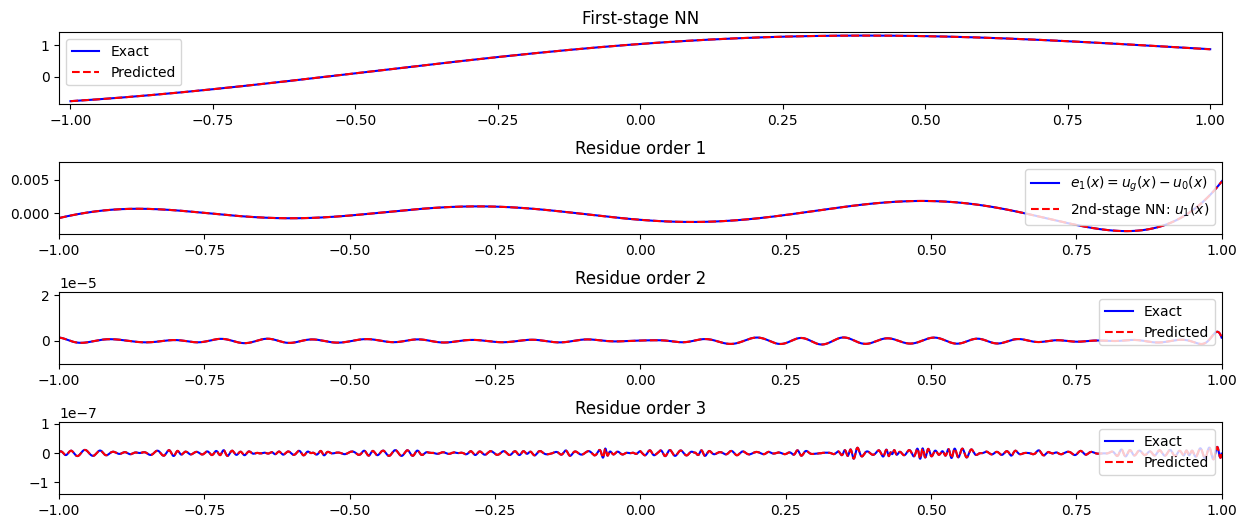

In [59]:
fig, axes = plt.subplots(4, 1, figsize=(15, 6))
fig.subplots_adjust(hspace=0.8)

axes[0].plot(x_eval.cpu(), u_eval.cpu(), 'b-', label='Exact')
axes[0].plot(x_eval.cpu(), u_p.cpu().detach(), 'r--', label='Predicted')
axes[0].set_xlim(low_bound_xtrain.cpu(), up_bound_xtrain.cpu())
axes[0].legend()
axes[0].set_title('First-stage NN')

axes[1].plot(x_train.cpu(), u_train2.cpu().detach(), 'b-', label=r'$e_1(x) = u_g(x) - u_0(x)$')
axes[1].plot(x_eval.cpu(), u_pred2.cpu().detach(), 'r--', label=r'2nd-stage NN: $u_1(x)$')
axes[1].set_xlim(-1, 1)
axes[1].legend()
axes[1].set_title('Residue order 1')

axes[2].plot(x_train_strengthening.cpu(), u_train3.cpu().detach(), 'b-', label='Exact')
axes[2].plot(x_eval.cpu(), u_pred3.cpu().detach(), 'r--', label='Predicted')
axes[2].set_xlim(-1, 1)
axes[2].legend()
axes[2].set_title('Residue order 2')

axes[3].plot(x_train_strengthening.cpu(), u_train4.cpu().detach(), 'b-', label='Exact')
axes[3].plot(x_eval.cpu(), u_pred4.cpu().detach(), 'r--', label='Predicted')
axes[3].set_xlim(-1, 1)
axes[3].legend()
axes[3].set_title('Residue order 3')

plt.show()

In [63]:
import numpy as np 
error_u = np.linalg.norm(u_eval.cpu() - u_p.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u2 = np.linalg.norm(u_eval.cpu() - u_p2.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u3 = np.linalg.norm(u_eval.cpu() - u_p3.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)
error_u4 = np.linalg.norm(u_eval.cpu() - u_p4.cpu().detach())/np.linalg.norm(u_eval.cpu(), 2)

print(f'Error of order 1: {error_u}')
print(f'Error of order 2: {error_u2}')
print(f'Error of order 3: {error_u3}')
print(f'Error of order 4: {error_u4}')

Error of order 1: 0.0012394788770585016
Error of order 2: 7.477933348353765e-07
Error of order 3: 5.989617253892555e-09
Error of order 4: 3.4728927416734456e-10
